In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().cwd().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

print("Added:", PROJECT_ROOT)

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("sys.path contains project root?:", str(PROJECT_ROOT) in sys.path)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import HANDataset, build_vocab, create_balanced_dataloader, split_by_pid

from models.attention_rnn.attention_model_v2 import AttentionHanV2
import yaml

# Load config
CONFIG_PATH = Path("config_grid.yaml")

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

data_cfg = config["data"]
root = Path(data_cfg["data_root"])

word_df = pd.read_csv(root / data_cfg["word_csv"])
sentence_df = pd.read_csv(root / data_cfg["sentence_csv"])
dialogue_df = pd.read_csv(root / data_cfg["dialogue_csv"])

import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

# 1. Building comprehensive vocab
all_texts = (
    word_df["Text"].tolist() + 
    sentence_df["Text"].tolist() + 
    dialogue_df["Text"].tolist()
)

vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

# 2-1. nltk (converting to hierarchical documents)
    # Working as a main source of data
train_df, val_df, test_df = split_by_pid(sentence_df)

train_dataset = HANDataset(train_df, vocab)
val_dataset   = HANDataset(val_df, vocab)
test_dataset  = HANDataset(test_df, vocab)

# 2-2. Index mapping (for each batch)
unique_scores = sorted(sentence_df["PHQ_Score"].unique())
score2idx = {score: idx for idx, score in enumerate(unique_scores)}
idx2score = {idx: score for score, idx in score2idx.items()}    

sentence_df["label_idx"] = sentence_df["PHQ_Score"].map(score2idx)
# 3. dataloaders
train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. verify shapes
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["label"].shape)
print(batch["pid"].shape)

# ---- Load model config ----
model_cfg = config["model_grid"]

# ---- Auto-select device ----
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

NUM_CLASSES = dialogue_df["PHQ_Score"].nunique()

Added: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ
CWD: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ/models/attention_rnn
PROJECT_ROOT: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ
sys.path contains project root?: True


[nltk_data] Downloading package punkt to /Users/sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocab size = 6265
torch.Size([16, 10, 30])
torch.Size([16])
torch.Size([16])
Using device: mps


In [2]:
model_cfg

{'embed_dim': [64, 128, 256],
 'hidden_dim': [32, 64, 128],
 'dropout': [0.1, 0.5],
 'max_words': [50, 100, 300],
 'max_sentences': [10, 20, 30]}

In [14]:
import yaml
import itertools
import torch
from torch.utils.data import DataLoader

model_grid = config["model_grid"]
training_grid = config["training_grid"]

# ---------------------------------------------------------
# Prepare grid search combinations
# ---------------------------------------------------------
def dict_product(dicts):
    keys = dicts.keys()
    values = dicts.values()
    for instance in itertools.product(*values):
        yield dict(zip(keys, instance))

model_configs = list(dict_product(model_grid))
train_configs = list(dict_product(training_grid))

print(f"Searching {len(model_configs) * len(train_configs)} combinations...")

# ---------------------------------------------------------
# Training Loop Placeholder
# ---------------------------------------------------------
def train_model(model_cfg, train_cfg, return_curve=False):

    criterion = nn.CrossEntropyLoss()

    model = AttentionHanV2(
        vocab_size=len(vocab),
        embed_dim=model_cfg["embed_dim"],
        hidden_dim=model_cfg["hidden_dim"],
        dropout=model_cfg["dropout"],
        num_classes=NUM_CLASSES,
        pad_idx=0,
        max_words=model_cfg["max_words"],
        max_sentences=model_cfg["max_sentences"]
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=float(train_cfg["learning_rate"]),
        weight_decay=float(train_cfg["weight_decay"])
    )

    best_val_loss = float("inf")

    train_curve = []
    val_curve = []

    for epoch in range(train_cfg["num_epochs"]):
        model.train()
        train_losses = []
        for batch in train_loader:
            docs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits, _, _ = model(docs)
            loss = criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                float(train_cfg["gradient_clip"])
            )
            optimizer.step()
            train_losses.append(loss.item())
        epoch_train_loss = sum(train_losses) / len(train_losses)
        train_curve.append(epoch_train_loss)
        
        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                docs = batch["input_ids"].to(device)
                labels = batch["label"].to(device)
                logits, _, _ = model(docs)
                val_losses.append(criterion(logits, labels).item())

        val_loss = sum(val_losses) / len(val_losses)
        val_curve.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    if return_curve:
        return model, train_curve, val_curve
    
    return best_val_loss


Searching 324 combinations...


In [ ]:
from tqdm import tqdm

results = []

# Calculate total for global bar
total_runs = len(model_configs) * len(train_configs)

with tqdm(total=total_runs, desc="Grid Search", unit="run") as pbar:
    for m_cfg in model_configs:
        for t_cfg in train_configs:
            
            val_loss = train_model(m_cfg, t_cfg)
            
            results.append({
                "model": m_cfg,
                "train": t_cfg,
                "val_loss": val_loss
            })
            
            pbar.update(1)   # update after each run


Grid Search: 100%|██████████| 324/324 [2:52:54<00:00, 32.02s/run]  


In [7]:
best_result = min(results, key=lambda x: x["val_loss"])

print("Best model config:", best_result["model"])
print("Best training config:", best_result["train"])
print("Best val_loss:", best_result["val_loss"])

Best model config: {'embed_dim': 64, 'hidden_dim': 128, 'dropout': 0.5, 'max_words': 100, 'max_sentences': 30}
Best training config: {'learning_rate': '1e-5', 'weight_decay': '1e-5', 'gradient_clip': 1.0, 'num_epochs': 5}
Best val_loss: 2.9181418895721434


In [15]:
best_model_cfg  = best_result["model"]
best_train_cfg  = best_result["train"]

final_model, train_curve, val_curve = train_model(
    best_model_cfg,
    best_train_cfg,
    return_curve=True
)

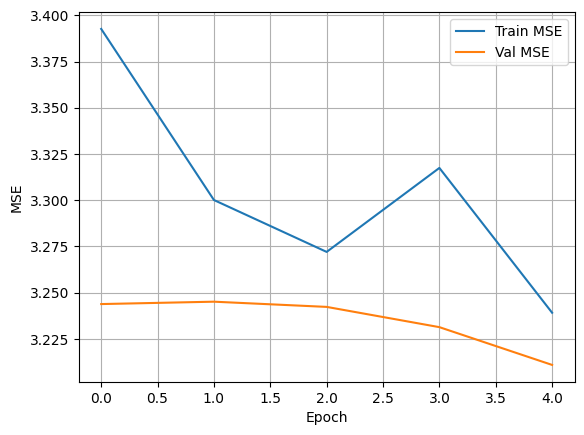

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_curve, label="Train MSE")
plt.plot(val_curve, label="Val MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()
